## Setting the environment

In [1]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## Loading dataset

In [ ]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("Project8_SentimentAnalysis_with_NeuralNetwork/a1_IMDB_Dataset.csv")



In [ ]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [44]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [45]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

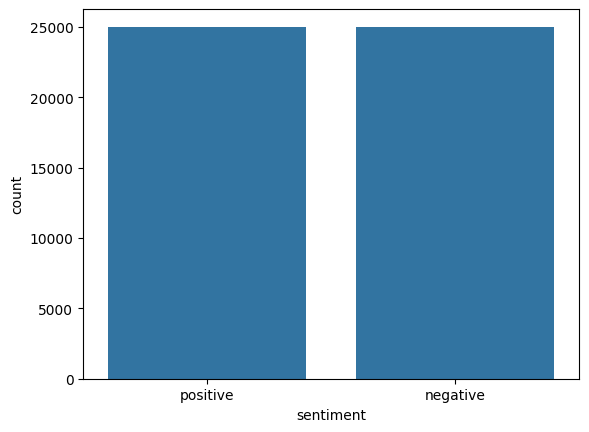

In [46]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [47]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers 
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [48]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [49]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SON\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [51]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [52]:
# Sample cleaned up movie review 

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [53]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

## Preparing embedding layer

Bây giờ chúng ta hãy viết tập lệnh cho lớp nhúng của chúng ta. Lớp nhúng chuyển đổi dữ liệu văn bản của chúng ta thành dạng số. Sau đó, nó được sử dụng làm lớp đầu tiên cho các mô hình học sâu trong Keras .


Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [55]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [56]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
#Thêm 1 để lưu trữ các kích thước cho các từ không có nhúng từ được đào tạo trước nào tồn tại
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [57]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [58]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open("Project8_SentimentAnalysis_with_NeuralNetwork/a2_glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [59]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.
# Tạo Ma trận nhúng có 100 cột
# Bao gồm nhúng từ GloVe 100 chiều cho tất cả các từ trong ngữ liệu của chúng tôi.
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [60]:
embedding_matrix.shape

(92394, 100)

# Model Training with:

## Recurrent Neural Network (LSTM)

In [61]:
from keras.layers import LSTM

In [62]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

c:\Users\SON\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [63]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [64]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 208ms/step - acc: 0.6894 - loss: 0.5717 - val_acc: 0.8084 - val_loss: 0.4440
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 209ms/step - acc: 0.8069 - loss: 0.4355 - val_acc: 0.8329 - val_loss: 0.3983
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 203ms/step - acc: 0.8365 - loss: 0.3788 - val_acc: 0.8429 - val_loss: 0.3636
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 232ms/step - acc: 0.8478 - loss: 0.3583 - val_acc: 0.8279 - val_loss: 0.3864
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 200ms/step - acc: 0.8603 - loss: 0.3318 - val_acc: 0.8635 - val_loss: 0.3265
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - acc: 0.8738 - loss: 0.3052 - val_acc: 0.8580 - val_loss: 0.3397


In [65]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - acc: 0.8597 - loss: 0.3359


In [66]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33640584349632263
Test Accuracy: 0.8601999878883362


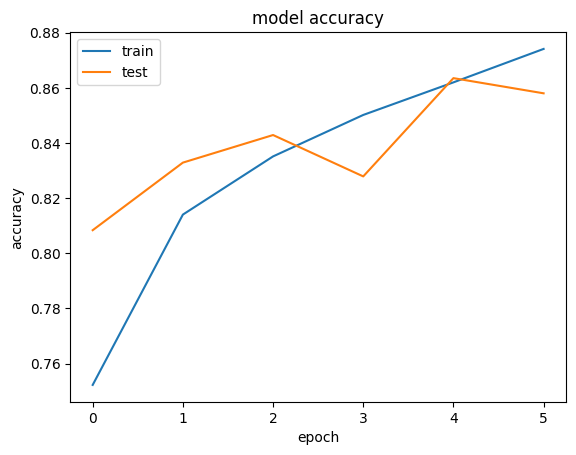

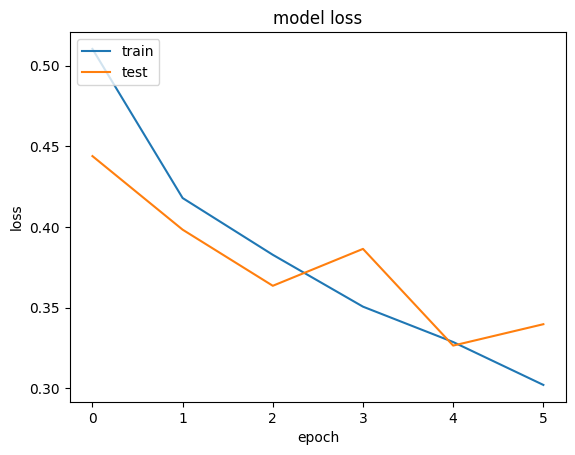

In [67]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [68]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

# Making Predictions on Live IMDb data

In [69]:
!ls # lists files in working directory

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [70]:
# # Load previously trained LSTM Model

# from keras.models import load_model

# model_path ='./c1_lstm_model_acc_0.856.h5'
# pretrained_lstm_model = load_model(model_path)

# # summarize model.
# pretrained_lstm_model.summary()

In [71]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("Project8_SentimentAnalysis_with_NeuralNetwork/a3_IMDb_Unseen_Reviews.csv")


sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,"Intelligent Movie.\nThis set is very funny, wa...",9
1,1,Ex Machina,"After watching, I don't understand fuck me.\n'...",10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nAfter ...",3
3,3,Ex Machina,"Had Great Potential.\nT immunity vs horror, bu...",1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [72]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [73]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [74]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


array([[0.77458   ],
       [0.96467847],
       [0.27681184],
       [0.6060935 ],
       [0.9413475 ],
       [0.23258322]], dtype=float32)

In [ ]:
# Writing model output file back to Google Drive
sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)
df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])
dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)
dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')
dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,"Intelligent Movie.\nThis set is very funny, wa...",9,7.7
1,Ex Machina,"After watching, I don't understand fuck me.\n'...",10,9.6
2,Ex Machina,"Poor story, only reasonable otherwise.\nAfter ...",3,2.8
3,Ex Machina,"Had Great Potential.\nT immunity vs horror, bu...",1,6.1
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.4
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,2.3


In [ ]:
sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments * 10, 1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns=['Predicted Sentiments'])
df_movie = pd.DataFrame(sample_reviews['Movie'], columns=['Movie'])
df_review_text = pd.DataFrame(sample_reviews['Review Text'], columns=['Review Text'])
df_imdb_rating = pd.DataFrame(sample_reviews['IMDb Rating'], columns=['IMDb Rating'])
dfx = pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)
dfx.to_excel("./c2_IMDb_Unseen_Predictions.xlsx", sheet_name='Predictions', index=False)
dfx.head(6)


,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,"Intelligent Movie.\nThis set is very funny, wa...",9,7.7
1,Ex Machina,"After watching, I don't understand fuck me.\n'...",10,9.6
2,Ex Machina,"Poor story, only reasonable otherwise.\nAfter ...",3,2.8
3,Ex Machina,"Had Great Potential.\nT immunity vs horror, bu...",1,6.1
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.4
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,2.3


In [ ]:
import pandas as pd
import numpy as np

# Đọc dữ liệu từ file Excel đầu vào
input_file_path = "./input_movie_reviews.xlsx"  # Thay thế bằng đường dẫn tệp của bạn
sample_reviews = pd.read_excel(input_file_path)

# Giả sử unseen_sentiments là kết quả dự đoán bạn đã tính toán
# Đây là một ví dụ, bạn có thể thay bằng mô hình dự đoán thực tế của bạn
# Ví dụ giả định unseen_sentiments là một mảng ngẫu nhiên giữa 0 và 1
unseen_sentiments = np.random.rand(len(sample_reviews))  # Dự đoán ngẫu nhiên

# Thêm cột "Predicted Sentiments" vào DataFrame
sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments * 10, 1)

# Trích xuất các cột cần thiết
df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns=['Predicted Sentiments'])
df_movie = pd.DataFrame(sample_reviews['Movie'], columns=['Movie'])
df_review_text = pd.DataFrame(sample_reviews['Review Text'], columns=['Review Text'])
df_imdb_rating = pd.DataFrame(sample_reviews['IMDb Rating'], columns=['IMDb Rating'])

# Ghép các bảng thành một DataFrame hoàn chỉnh
dfx = pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

# Ghi DataFrame vào một file Excel mới
output_file_path = "./output_movie_predictions.xlsx"  # Tên file Excel đầu ra
dfx.to_excel(output_file_path, sheet_name='Predictions', index=False)

# Hiển thị 6 dòng đầu tiên của DataFrame để kiểm tra
dfx.head(6)